<h2><center>MNIST classification using Numpy</center></h2>


# Importing Numpy and Keras

In [0]:
import numpy as np
# Importing the Keras main module forcing tensorflow 1.x backend
#import sys
#!conda install --yes --prefix {sys.prefix} tensorflow
#!conda install --yes --prefix {sys.prefix} keras
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 1.15.0
Using keras version 2.2.5


In [0]:
#Additionnal resources
import psutil
from sklearn.preprocessing import StandardScaler

# Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets
Verify the amount of system memory available before and after loading the dataset.

In [0]:
print('Avant de charger la bibliothèque: %f' %(psutil.virtual_memory()[1]))

Avant de charger la bibliothèque: 12665741312.000000


In [0]:
#@title
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
# START CODE HERE
print('Après : %f' %(psutil.virtual_memory()[1]) )
print('Faible variation mémoire')
# END CODE HERE


Après : 12665565184.000000
Faible variation mémoire


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the fist sample of the training set:

11493376/11490434 [==============================] - 1s 0us/step
Je ne reconnais pas moi-même le numéro ... ahah


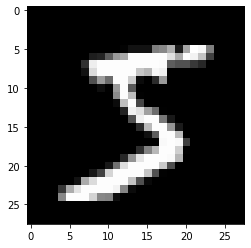

In [0]:
# Let us visualize the first training sample using the Gnuplot library
from matplotlib import pyplot as plt
# START CODE HERE
(X_train,y_train),(X_test,y_test) = mnist.load_data()
plt.imshow(X_train[0],cmap = 'gray') #ajouter cmap pour du noir et blanc
print("Je ne reconnais pas moi-même le numéro ... ahah")
# END CODE HERE

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

In [0]:
from keras.utils.np_utils import to_categorical
# START CODE HERE
y_train_OH = to_categorical(y_train, num_classes=10, dtype ='uint8' )
y_test_OH  = to_categorical(y_test, num_classes=10, dtype ='uint8' )
print('One Hot Encoded train labels examples:  %s , %s' %(str(y_train_OH[0]),str(y_train_OH[10])))
print('One Hot Encoded test  labels examples:  %s , %s' %(str(y_test_OH[2]),str(y_train_OH[3])))
# END CODE HERE

One Hot Encoded train labels examples:  [0 0 0 0 0 1 0 0 0 0] , [0 0 0 1 0 0 0 0 0 0]
One Hot Encoded test  labels examples:  [0 1 0 0 0 0 0 0 0 0] , [0 1 0 0 0 0 0 0 0 0]


Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```,

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

In [0]:
# Reshape to proper images with 1 color channel according to backend scheme


    
# START CODE HERE
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
X_train_col = X_train.reshape(X_train.shape[0],-1)
if (X_train_col[0].shape[0] != img_cols*img_rows):
    print('X_train_col size : %i != img_cols* img_rows : %i '%(X_train_col[0].shape[0], img_cols*img_rows))
    raise Exception("Error reshaping")
# END CODE HERE

# Cast pixels from uint8 to float32
X_train_col = X_train_col.astype('float32')

##Same for X_test
X_test_col = X_test.reshape(X_test.shape[0],-1)

# Cast pixels from uint8 to float32
X_test_col = X_test_col.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE
scaler = StandardScaler()
StandardScaler.fit(scaler,X_train_col)
X_train_col = StandardScaler.transform(scaler,X_train_col)
print('Feature matrix mean : %f standard deviation : %f'%(np.mean(X_train_col),np.std(X_train_col)))
# END CODE HERE

Feature matrix mean : 0.000000 standard deviation : 0.956316


# Working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

## Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.

In [0]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with no hidden layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """
    # START CODE HERE
    W = np.zeros((n_output, n_input))
    b = np.zeros(n_output)
    for i in range(n_output):
        for j in range(n_input):
            W[i,j] = np.random.normal()
        b[i] = np.random.normal()
    nb_params = n_output*n_input + n_output
    # END CODE HERE
    return W, b, nb_params

In [0]:
n_training = X_train_col.shape[0] 
n_feature = X_train_col.shape[1] 
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)



In [0]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """
    z = np.dot(W,X) + b
    return z

## Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 

In [0]:
import scipy.special as sp
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    out = sp.softmax(z) # CODE HERE
    return out

## Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} - \nabla_{\mathbf{W}} l_{ML} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{ML}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{ML}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$


Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} - \frac{\delta l_{ML}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{ML}}{\delta W_{ij}} = \frac{\delta l_{ML}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{ML} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{ML}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{ML}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{ML} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{ML}$ and $\nabla_{\mathbf{b}} l_{ML}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

Assuming the loss function is the mean squared error:
$$l = \frac{1}{2}(softmax(Wx +b)-y)^2$$
We have : 
$$\frac{\partial l}{\partial b} = \frac{\partial l}{\partial z} \frac{\partial z}{\partial b}$$
Given that :
$$ \frac{\delta l_{ML}}{\delta z} = \mathbf{o} - \mathbf{y} $$
and : 
$$ \frac{\delta z}{\delta b} = \mathbf{1} $$
We have then : 
$$\frac{\partial l}{\partial b} = \mathbf{o} - \mathbf{y}$$

In [0]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    grad_1 = grad.reshape(10,1) #easier to compute the dot product
    X_1 = X.reshape(784,1)
    grad_w = np.dot(grad_1,X_1.T)
    #Assuming the loss function is the mean squared error
    grad_b = grad
        
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    return W, b

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function:

In [0]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        return param - eta*grad_param
    elif regularizer=='L2':
        return  # CODE HERE
    else:
        raise NotImplementedError

## Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.

In [0]:
import pdb
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : b: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    ###Computing predictions
    #Je suppose ici que X est le vecteur qui contient toutes les données
    #ce qui est un peu perturbant vis à vis du début
    y_pred = [] #vecteur contient les prédictions
    for x in X:
        ### Forward propagation
        z = softmax(forward(W,b,x))
        ### Compute the softmax and the prediction
        pred = np.zeros(z.shape[0])
        pred[np.argmax(z)]+=1
        y_pred.append(pred)
    y_pred = np.array(y_pred)
    ### Compute the accuracy
    temp = np.abs(y_pred - labels)
    accuracy = np.sum((1 - 1/2*np.sum(temp, axis =1 ))/y_pred.shape[0], axis = 0)#la somme de temp vaut 2 si 
    #on se trompe et 0 sinon
      
    return y_pred,temp,accuracy

In [0]:
y_pred,temp,accuracy = computeAcc(W,b,X_train_col,y_train_OH)

In [0]:
accuracy

0.16063333333333332

## Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each trainin example once. 

In [0]:
# Optimization
eta = 0.01
regularizer = None
weight_decay = 0.0001

# Training
log_interval = 5000

In [0]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

#######################
### Learning process ##
#######################
for j in range(n_training):
    ### Getting the example
    X, y = X_train_col[j], y_train_OH[j]

    ### Forward propagation
    z = forward(W,b,X)

    ### Compute the softmax
    out = softmax(z)
        
    ### Compute the gradient at the top layer
    derror = out - y # This is o - y 

    ### Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay)

    if j % log_interval == 0:
        ### Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, X_train_col, y_train_OH) 

        ### And the testing accuracy
        test_accuracy = computeAcc(W, b, X_test_col, y_test_OH) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        result_line = str(int(j)) + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = "Final result:" + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
print(result_line)     

0 (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]]), 0.16128333333333333) (array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 0.1577)

What can you say about the performance of this simple linear classifier ? 

Test results are pretty low. It does not work pretty well. But it's about normal we did use only one layer, making a perceptron. Linear classification isn't very good for making differences between a 5 and a 7 for instance. 

<h1><center>MNIST classification using Keras<center></h1>

# Importing Keras

In [0]:
# Importing the Keras main module forcing tensorflow 1.x backend
import numpy as np
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using TensorFlow backend.


Using tensorflow version 1.15.0
Using keras version 2.2.5


## Loading and preparing the MNIST dataset

Load the MNIST dataset via keras.datasets. Again, turn train and test labels into one-hot encoding, and reshape and normalize data as in the first exercise. 

11493376/11490434 [==============================] - 1s 0us/step
Je ne reconnais pas moi-même le numéro ... ahah


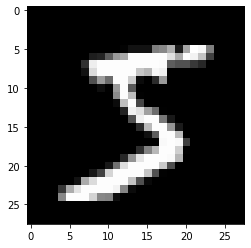

In [0]:
#@title
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
from matplotlib import pyplot as plt
# START CODE HERE
(X_train,y_train),(X_test,y_test) = mnist.load_data()
plt.imshow(X_train[0],cmap = 'gray') #ajouter cmap pour du noir et blanc
print("Je ne reconnais pas moi-même le numéro ... ahah")
# END CODE HERE


In [0]:
from keras.utils.np_utils import to_categorical
# START CODE HERE
y_train_OH = to_categorical(y_train, num_classes=10, dtype ='uint8' )
y_test_OH  = to_categorical(y_test, num_classes=10, dtype ='uint8' )
print('One Hot Encoded train labels examples:  %s , %s' %(str(y_train_OH[0]),str(y_train_OH[10])))
print('One Hot Encoded test  labels examples:  %s , %s' %(str(y_test_OH[2]),str(y_train_OH[3])))
# END CODE HERE


One Hot Encoded train labels examples:  [0 0 0 0 0 1 0 0 0 0] , [0 0 0 1 0 0 0 0 0 0]
One Hot Encoded test  labels examples:  [0 1 0 0 0 0 0 0 0 0] , [0 1 0 0 0 0 0 0 0 0]


In [0]:
# Reshape to proper images with 1 color channel according to backend scheme
# START CODE HERE
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
X_train_col = X_train.reshape(X_train.shape[0],-1)
if (X_train_col[0].shape[0] != img_cols*img_rows):
    print('X_train_col size : %i != img_cols* img_rows : %i '%(X_train_col[0].shape[0], img_cols*img_rows))
    raise Exception("Error reshaping")
# END CODE HERE

# Cast pixels from uint8 to float32
X_train_col = X_train_col.astype('float32')

#Do the same for the test set 
X_test_col = X_test.reshape(X_test.shape[0],-1)
X_test_col = X_test_col.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE
scaler = StandardScaler()
StandardScaler.fit(scaler,X_train_col)
X_train_col = StandardScaler.transform(scaler,X_train_col)
print('Feature matrix mean : %f standard deviation : %f'%(np.mean(X_train_col),np.std(X_train_col)))
# END CODE HERE

Feature matrix mean : 0.000000 standard deviation : 0.956316


## Defining the neural network architecture (i.e., the network model)

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic information on how to use numpy.

First, try to replicate the classifier of the first exercise. Secondly, create a fully connected network.
For the fully connected layer, you can for example use this architecture: 
$$ (784) \rightarrow (300) \rightarrow (10) $$
For this first implementation of the network, use only sigmoid activations in the hidden layer. Remember to use the right output activation function ! 

In [0]:
# The Sequential module is a container for more complex NN elements and
# defines a loop-less NN architecture
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# START CODE HERE
############## CLASSIFIER OF THE FIRST EXERCISE ##############
model_ex1 = Sequential()
model_ex1.add(Dense(10,input_dim = 784,activation ='softmax'))
model_ex1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy']) 
model_ex1.fit(X_train_col, y_train_OH)
acc = model_ex1.evaluate(X_train_col,y_train_OH)
val_acc = model_ex1.evaluate(X_test_col,y_test_OH)
print('Training accuracy : %f Validation score : %f' %(acc[1],val_acc[1]))
# END CODE HERE








Epoch 1/1





10000/10000 [==============================] - 0s 45us/step
Training accuracy : 0.922600 Validation score : 0.808200


In [0]:
############## FULLY CONNECTED NETWORK ##############  
model = Sequential()
model.add(Dense(300,input_dim = 784,activation ='sigmoid'))
model.add(Dense(10,input_dim = 784,activation ='softmax')) #softmax préférée à sigmoid pour une classification binaire (donne des probas d'appartenance aux classes)

Instantiate a SGD optimizer with a tentative learning rate of $\\eta = 10^{-2}$ and, using the appropriate loss function (which is called, in keras, ```'categorical_crossentropy'```) and compile the model.

In [0]:
# The optimizers module provides a number of optimization algorithms for updating
# a netwok parameters accoridng to the computed error gradints
from keras import optimizers

# START CODE HERE
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy']) 
# END CODE HERE
# We can now have a look at the defined model topology
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


## Training the network

Train the model for 10 epochs using the ```.fit()``` method, validating the model at each epoch and keeping track of the training history for later plotting. Make sure you enable ```.fit()``` verbose mode in order to visualize the training.

In order to accelerate training, use the ```batch_size``` option of ```.fit()```, which will process a batch of examples at the same time, and make one update for all of them, averaged over the gradients for each training example of the batch. You can begin with a small size, and experiment with a larger size later.

In [0]:
# This is where the actual training-testing happens
# Number of epochs we want to train
epochs = 10
batch_size = None
# START CODE HERE
history = model.fit(X_train_col, y_train_OH, epochs = epochs, batch_size = batch_size, validation_data = (X_test_col,y_test_OH))
# END CODE HERE

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.9552 - acc: 0.7738 - val_loss: 0.9613 - val_acc: 0.6710
Epoch 2/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.4066 - acc: 0.8923 - val_loss: 0.9498 - val_acc: 0.6912
Epoch 3/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.3387 - acc: 0.9060 - val_loss: 0.8638 - val_acc: 0.7275
Epoch 4/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.3078 - acc: 0.9131 - val_loss: 0.8100 - val_acc: 0.7518
Epoch 5/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.2887 - acc: 0.9182 - val_loss: 0.7562 - val_acc: 0.7751
Epoch 6/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.2747 - acc: 0.9215 - val_loss: 0.7499 - val_acc: 0.7822
Epoch 7/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.2639 - acc: 0.9243 - val_loss: 0.7108 - val_acc

## Visualizing the network performance

Visualize the training history using the ```pyplot``` package:
- In one graph, plot the train and vaidation loss functions,
- In another graph, the train and validation accuracy.
By comparing the training the testing curves, what can we conclude about the quality of the training ?

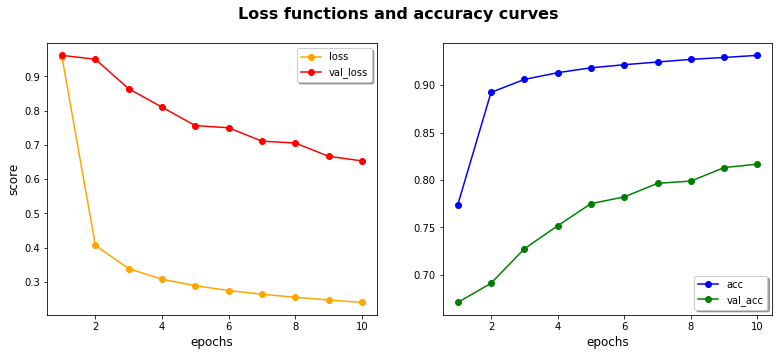

In [0]:
# We now want to plot the train and validation loss functions and accuracy curves

# summarize history for loss
# START CODE HERE
fig, ax = plt.subplots(1,2, figsize = (13,5))
fig.suptitle('Loss functions and accuracy curves',size = 16, weight = 'semibold')
ax[0].plot(range(1,epochs+1),history.history['loss'], marker = 'o', color = 'orange', label = 'loss')
ax[0].plot(range(1,epochs+1),history.history['val_loss'], marker = 'o', color = 'red', label = 'val_loss')
ax[0].set_ylabel('score',size = 'large')
ax[0].set_xlabel('epochs', size = 'large')
ax[0].legend(loc = 'upper right',shadow = True)
# END CODE HERE

# summarize history for accuracy
# START CODE HERE
ax[1].plot(range(1,epochs+1),history.history['acc'], marker = 'o', color = 'blue', label = 'acc')
ax[1].plot(range(1,epochs+1),history.history['val_acc'], marker = 'o', color = 'green', label = 'val_acc')
ax[1].set_xlabel('epochs',size = 'large')
ax[1].legend(loc = 'lower right', shadow = True)
# END CODE HERE
plt.show()


**Answer** : The training score is very good (above 0.96), which shows that the model fits very well to the data. We could be worried about overfitting, but as the validation score is good (around 0.8) the model generalizes well.

## Experiments

Note down the performance of the larger network in terms of training and validation accuracy as a reference (save the loss/accuracy graphs of the network).

Then, experiment as follow and compare performance with the reference scenario:

*  Experiment increasing the size of the batch and compare the performance with reference.
*  Experiment replacing the sigmoid activations with Relus and note what happens.
*  Experiment with a larger architecture, for example: 
$$ (784) \rightarrow (300) \rightarrow (128) \rightarrow (84) \rightarrow (10) $$

In [0]:
############## BATCH SIZE COMPARISON ##############
from time import time
def batch_influence(batch_size):
  t_1 = time()
  history = model.fit(X_train_col, y_train_OH, epochs = epochs, batch_size = batch_size, validation_data = (X_test_col,y_test_OH))
  print('Computation time : %f' %(time()-t_1))
  #Plotting results
  fig, ax = plt.subplots(1,2, figsize = (13,5))
  fig.suptitle('Loss functions and accuracy curves batch_size : ' + str(batch_size),size = 16, weight = 'semibold')
  ax[0].plot(range(1,epochs+1),history.history['loss'], marker = 'o', color = 'orange', label = 'loss')
  ax[0].plot(range(1,epochs+1),history.history['val_loss'], marker = 'o', color = 'red', label = 'val_loss')
  ax[0].set_ylabel('score',size = 'large')
  ax[0].set_xlabel('epochs', size = 'large')
  ax[0].legend(loc = 'center',shadow = True)
  ax[1].plot(range(1,epochs+1),history.history['acc'], marker = 'o', color = 'blue', label = 'acc')
  ax[1].plot(range(1,epochs+1),history.history['val_acc'], marker = 'o', color = 'green', label = 'val_acc')
  ax[1].set_xlabel('epochs',size = 'large')
  ax[1].legend(loc = 'center', shadow = True)
  plt.show()
  return 


Batch sizes determine with what precision we compute the gradient. At each step we compute an estimation of the gradient based on our data and our labels. The larger the batch size the better the approximation of the gradient, but it requires a lot of computation with less than linear returns. 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 3us/step - loss: 0.1297 - acc: 0.9646 - val_loss: 0.4165 - val_acc: 0.8837
Epoch 2/10
60000/60000 [==============================] - 0s 3us/step - loss: 0.1296 - acc: 0.9646 - val_loss: 0.4162 - val_acc: 0.8837
Epoch 3/10
60000/60000 [==============================] - 0s 3us/step - loss: 0.1296 - acc: 0.9646 - val_loss: 0.4167 - val_acc: 0.8837
Epoch 4/10
60000/60000 [==============================] - 0s 2us/step - loss: 0.1296 - acc: 0.9646 - val_loss: 0.4163 - val_acc: 0.8837
Epoch 5/10
60000/60000 [==============================] - 0s 3us/step - loss: 0.1296 - acc: 0.9646 - val_loss: 0.4163 - val_acc: 0.8837
Epoch 6/10
60000/60000 [==============================] - 0s 3us/step - loss: 0.1297 - acc: 0.9646 - val_loss: 0.4163 - val_acc: 0.8837
Epoch 7/10
60000/60000 [==============================] - 0s 3us/step - loss: 0.1296 - acc: 0.9646 - val_loss: 0.4160 - val_acc: 0.883

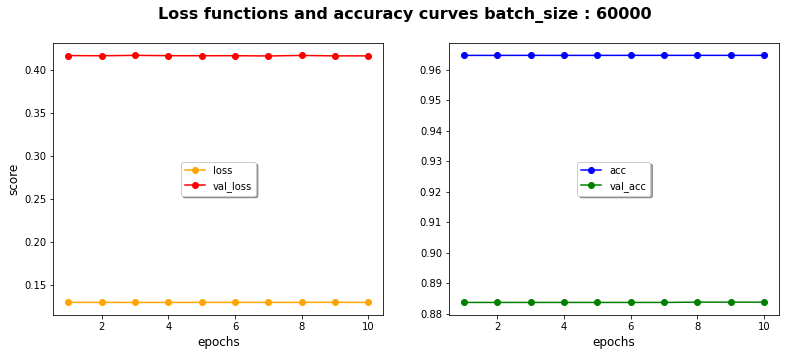

In [0]:
#On all the training set : Determininstic gradient descent
batch_influence(60000)

On large batch, epochs seem to have no influence. It could be understood in this way : because the size of the batch is large, there is not so much data for the training and the model fits quickly.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1302 - acc: 0.9643 - val_loss: 0.4147 - val_acc: 0.8827
Epoch 2/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1280 - acc: 0.9650 - val_loss: 0.4104 - val_acc: 0.8855
Epoch 3/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1256 - acc: 0.9658 - val_loss: 0.3995 - val_acc: 0.8883
Epoch 4/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1234 - acc: 0.9662 - val_loss: 0.4081 - val_acc: 0.8858
Epoch 5/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.1212 - acc: 0.9670 - val_loss: 0.3998 - val_acc: 0.8898
Epoch 6/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.1190 - acc: 0.9675 - val_loss: 0.3933 - val_acc: 0.8902
Epoch 7/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.1170 - acc: 0.9682 - val_loss: 0.3858 - val_acc

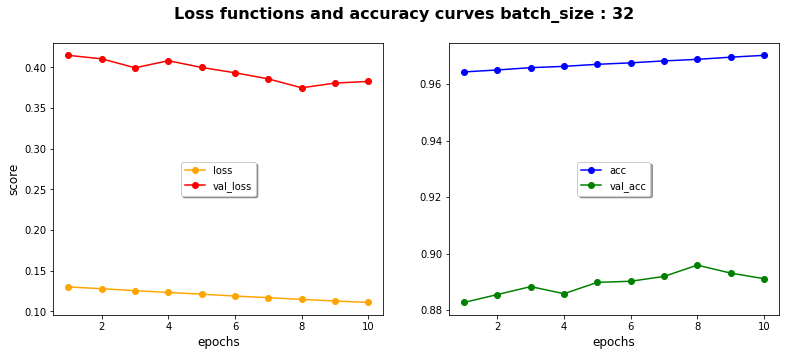

In [0]:
#Mini batch : the best trade-off between quickness and precision
batch_influence(32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 148s 2ms/step - loss: 0.1337 - acc: 0.9607 - val_loss: 0.4475 - val_acc: 0.8772
Epoch 2/10
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0900 - acc: 0.9731 - val_loss: 0.3367 - val_acc: 0.9068
Epoch 3/10
60000/60000 [==============================] - 148s 2ms/step - loss: 0.0619 - acc: 0.9815 - val_loss: 0.3211 - val_acc: 0.9105
Epoch 4/10
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0416 - acc: 0.9891 - val_loss: 0.2643 - val_acc: 0.9256
Epoch 5/10
60000/60000 [==============================] - 150s 3ms/step - loss: 0.0290 - acc: 0.9933 - val_loss: 0.3214 - val_acc: 0.9127
Epoch 6/10
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0211 - acc: 0.9960 - val_loss: 0.3223 - val_acc: 0.9160
Epoch 7/10
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0156 - acc: 0.9978 - val_loss: 0.2914 - 

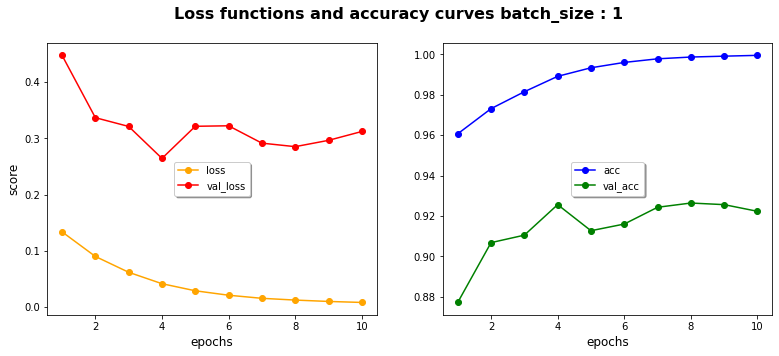

In [0]:
#Stochastic gradient descent
batch_influence(1)

Changing the batch size has a real impact on the both the training and validation score. The tinier the batch the better the score but at the cost of the computing time (nearly half an hour to have an increase of 0.03 of the validation score). 32 seems to be a good compromise

In [0]:
######## CHANGING ACTIVATION FUNCTION ###########
#### RELU ####
model = Sequential()
model.add(Dense(300,input_dim = 784,activation ='relu'))
model.add(Dense(10,input_dim = 784,activation ='softmax')) 
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy']) 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.0594 - acc: 0.9852 - val_loss: 1.1474 - val_acc: 0.9255
Epoch 2/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.0549 - acc: 0.9869 - val_loss: 1.1540 - val_acc: 0.9252
Epoch 3/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0505 - acc: 0.9879 - val_loss: 1.1069 - val_acc: 0.9291
Epoch 4/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.0467 - acc: 0.9889 - val_loss: 1.1309 - val_acc: 0.9268
Epoch 5/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.0434 - acc: 0.9900 - val_loss: 1.0649 - val_acc: 0.9315
Epoch 6/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.0404 - acc: 0.9911 - val_loss: 1.0849 - val_acc: 0.9298
Epoch 7/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.0378 - acc: 0.9918 - val_loss: 1.1456 - 

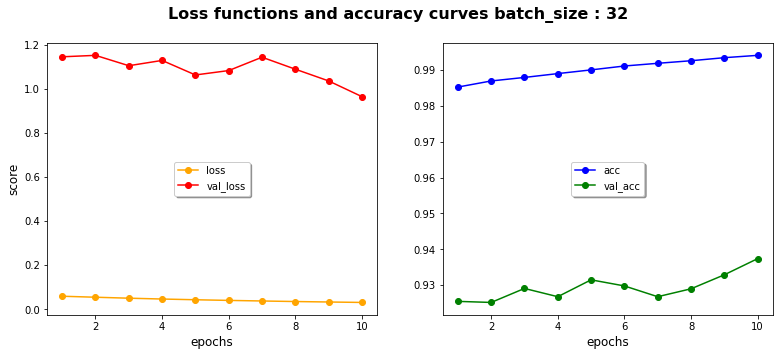

In [0]:
epochs = 10
batch_influence(32)

Changing the activation function in the hidden layer has a noticeable impact on both the losses and the scores. Quite frankly I can't explain why it happened that way. It seems like there is some magic in the hidden layer. An explanation might be that sigmoid tends to kill gradients in the areas close to zero and one and thus alter backpropagation.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.4217 - acc: 0.8778 - val_loss: 0.8791 - val_acc: 0.7339
Epoch 2/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.2674 - acc: 0.9221 - val_loss: 0.7352 - val_acc: 0.7848
Epoch 3/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.2303 - acc: 0.9343 - val_loss: 0.7481 - val_acc: 0.7788
Epoch 4/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.2046 - acc: 0.9421 - val_loss: 0.5647 - val_acc: 0.8379
Epoch 5/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.1841 - acc: 0.9495 - val_loss: 0.5472 - val_acc: 0.8418
Epoch 6/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.1668 - acc: 0.9535 - val_loss: 0.5137 - val_acc: 0.8542
Epoch 7/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.1519 - acc: 0.9585 - val_loss: 0.4919 - 

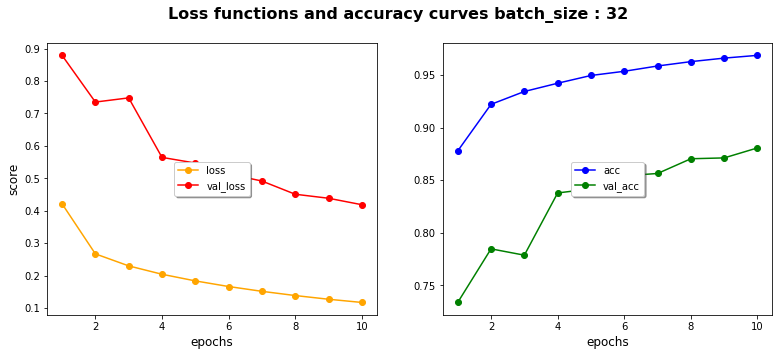

In [0]:
#### Tanh ####
model = Sequential()
model.add(Dense(300,input_dim = 784,activation ='tanh'))
model.add(Dense(10,input_dim = 784,activation ='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy']) 
epochs = 10
batch_influence(32)

tanh is pretty lame however

In [0]:
######## ADDING DEPTH ########

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_24 (Dense)             (None, 84)                10836     
_________________________________________________________________
dense_25 (Dense)             (None, 10)                850       
Total params: 285,714
Trainable params: 285,714
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.4180 - acc: 0.8833 - val_loss: 2.8827 - val_acc: 0.8128
Epoch 2/10
60000/60000 [==============================] -

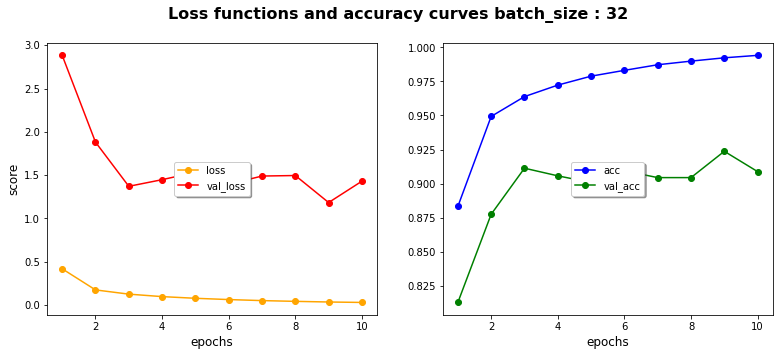

In [0]:
model = Sequential()
model.add(Dense(300,input_dim = 784,activation ='relu'))
model.add(Dense(128,activation ='relu'))
model.add(Dense(84,activation ='relu'))
model.add(Dense(10,activation ='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy']) 
model.summary()
epochs = 10
batch_influence(32)

If we compare with then neural network with one hidden layer and the same activation functions and batch size, the results are slightly worse on the validation score. It might be that the model is slightly more fit to the training data because of all the layers we added.